In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch, urllib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.fft as fft

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drunet/pytorch/default/1/drunet.py


## Hypothèses

- image avec du bruit corrélé
- le kernel suit un padding circulaire

## Démarche

Une image avec du bruit corrélé peut être définie comme (équation 8 de l'article plug and play) :

$$
y = x + k \otimes n, \quad n \sim \mathcal{N}(0, \sigma^2 I)
$$

avec :
-  y : l’imae bruitée
-  x : l’image originale (non bruitée)
-  k : le noyau de convolution
-  n : bruit blanc gaussien

---

## Étape "data term"

Dans le schéma ADMM / HQS, on doit résoudre (équation 6a du papier) :
A la différence de l'équation dans plug and play, T(x) = Kx car ici Kx est la transformation que l'on applique à l'image (application de bruit corrélé)

$$
x^{(t+1)} = \arg \min_x \; \frac{1}{2\sigma^2} \| y - Kx \|_2^2 + \frac{\rho}{2} \| x - z^{(t)} \|_2^2       (1)
$$

où :
- K  est l’opérateur de convolution associé à \( k \),
-  z(t) vient de l’étape de prior (denoiser),
- rho > 0  est un paramètre de pénalisation (que l'on peut fine tuner ?)

la premiere partie de l'équation assure que l'on reste proche de l'image d'origine, la seconde partie force x à rester proche de la version non bruitée de l'étape précédente z(t).
la premiere partie et la seconde partie de l'équation sont séparées et traiter séparement et itérativement dans la boucle data_step.

---

## Passage dans le domaine de Fourier

Pourquoi on passe dans le domaine de fourier ? 
sans Fourier : il faudrait différencier (1) par rapport à X et pour trouver la close forme solution inverser K.T @ K+ρI ce qui est coûteux
avec Fourier : on a une division par un scalaire en chaque fréquence, donc bcp + rapide.


Comme K est une convolution (avec circular padding), on a :

$$
\mathcal{F}(Kx) = \hat{k} \cdot \hat{x}
$$

avec la transformée de Fourier définit par : 
$$ 
\hat{x}[u,v] = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} 
x[m,n] \, e^{- j 2\pi \left(\frac{um}{M} + \frac{vn}{N}\right)}
$$

qu'on appelle sur pytorch par fft.fft2(X).real


où :
- $ k chapeau = \mathcal{F}(k) \ $est la transformée de Fourier du noyau,
- le produit est point-à-point.

Le problème devient alors, pour chaque fréquence omega :

$$
\hat{x}(\omega) = \frac{\overline{\hat{k}(\omega)} \cdot \hat{y}(\omega) / \sigma^2 + \rho \, \hat{z}(\omega)}
{|\hat{k}(\omega)|^2 / \sigma^2 + \rho}
$$

Puis on revient dans le domaine spatial :

$$
x^{(t+1)} = \mathcal{F}^{-1}(\hat{x})
$$

avec l'inverse de la transformé de Fourier définit par : 
$$
x[m,n] = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} 
\hat{x}[u,v] \, e^{+ j 2\pi \left(\frac{um}{M} + \frac{vn}{N}\right)}
$$

qu'on appelle sur pytorch par fft.ifft2(X).real

---

## Étape "prior"

On applique ensuite un débruiteur digne de ce nom comme Drunet :

$$
z^{(t+1)} = D_\theta \big( x^{(t+1)} \big)
$$

---

## Boucle Plug-and-Play

Puis on itère K fois avec en premier résolution de l'équation (1) puis denoiser :

1. **Data step (Fourier)** :
   $$
   x^{(t+1)} = \arg\min_x \frac{1}{2\sigma^2}\| y - Kx \|^2 + \frac{\rho}{2}\| x - z^{(t)} \|^2
   $$

2. **Prior step (denoiser)** :
   $$
   z^{(t+1)} = D_\theta(x^{(t+1)})
   $$

3. et on répète


### Creating an image with correlated noise

In [22]:
url = "https://boofcv.org/images/f/fe/Original_lena512.jpg"
image = Image.open(urllib.request.urlopen(url))
img_gray = image.convert("L")
image_np = np.array(img_gray)
image_torch = torch.from_numpy(image_np).float()

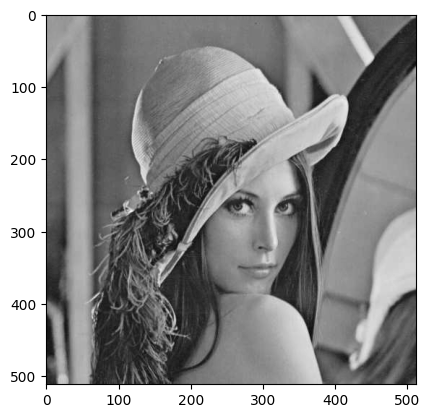

In [23]:
plt.imshow(image_torch, cmap="gray")

In [24]:
H, W = image_torch.shape[0], image_torch.shape[1]   

# Générer bruit blanc
sigma = 100.0
noise_white = torch.randn(1,1,H,W) * sigma 

# noyau
def gaussian_kernel(size=3, sigma=1.0):
    ax = torch.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

k = gaussian_kernel(size=3, sigma=1.0)         
k = k.unsqueeze(0).unsqueeze(0)                 

# convolution circulaire
noise_white_padded = F.pad(noise_white, (1, 1, 1, 1), mode="circular")  
noise_corr = F.conv2d(noise_white_padded, k, padding=0)



image_noised = image_torch + noise_corr


In [25]:
# k étant le kernel, on a bien un bruit qui est corrélé autour du pixel central de part la "symétrie" de la k
k

tensor([[[[0.0751, 0.1238, 0.0751],
          [0.1238, 0.2042, 0.1238],
          [0.0751, 0.1238, 0.0751]]]])

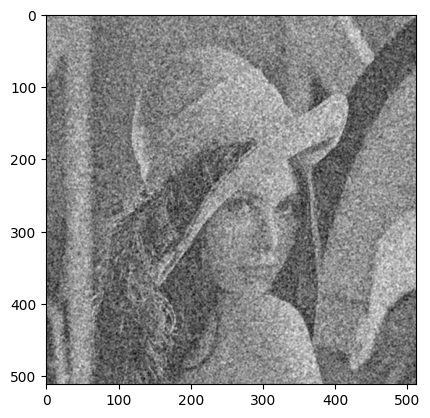

In [26]:
plt.imshow(image_noised[0][0],  cmap="gray")

### Unrolled net

In [27]:
#proxy of drunet for lighter model for now
#padding de 1 pour le moment pour que l'image de sortie soit de même dimension que l'input mais on pourra faire évoluer ça
#class SimpleDenoiser(nn.Module):
#    #channels =1 c'est parce qu'on veut des images en noir et blanc, si RGB mettre 3
#    def __init__(self, channels=1):
#        super().__init__()
#        self.net = nn.Sequential(nn.Conv2d(channels, 64, 3, padding=1),
#                    nn.ReLU(),
#                    nn.Conv2d(64, channels, 3, padding=1)
#                                )
#    def forward(self, x):
#        return self.net(x)

# === GPU CONFIGURATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


import sys
sys.path.append("/kaggle/input/drunet/pytorch/default/1")

from drunet import DRUNet

# Exemple d’utilisation :


# Plug-and-Play Unrolled Net
class PnPUnrolled(nn.Module):
    def __init__(self, kernel, K=5, sigma=0.01):
        super().__init__()
        self.K = K           # nombre d'itérations/unrolled blocks
        self.sigma = sigma
        self.denoiser = DRUNet().to(device)

        # Fourier transform, we assume circular convolution, is it the case ?
        self.kernel = kernel
        pad = (512 - kernel.shape[0], 512 - kernel.shape[1])
        k_padded = F.pad(kernel, (0, pad[1], 0, pad[0]))
        self.Hf = fft.fft2(k_padded)  # FFT du noyau

    def data_step(self, y, z, rho):
        """
        Etape data : résolution analytique
        (y : c'est l'observation, z : la variable prior, rho : le paramètre de pénalisation)
        """
        Y = fft.fft2(y)
        Z = fft.fft2(z)

        denom = (torch.abs(self.Hf)**2 / self.sigma**2 + rho)
        X = (torch.conj(self.Hf) * Y / self.sigma**2 + rho * Z) / denom
        x = fft.ifft2(X).real
        return x

    def forward(self, y):
        # init
        x = y.clone()
        z = y.clone()
        rho = 1.0

        for _ in range(self.K):
            #Data step
            x = self.data_step(y, z, rho)

            #rajout de cette ligne sinon importante perte de contraste dans l'image (tout en gris avec très peu de nuances)
            #x = torch.clamp(x, 0, 255)

            # Prior step (denoiser appliqué sur x)
            z = self.denoiser(x)

        return x


Using device: cuda


### test

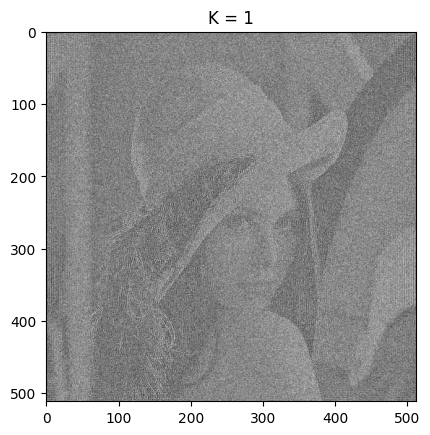

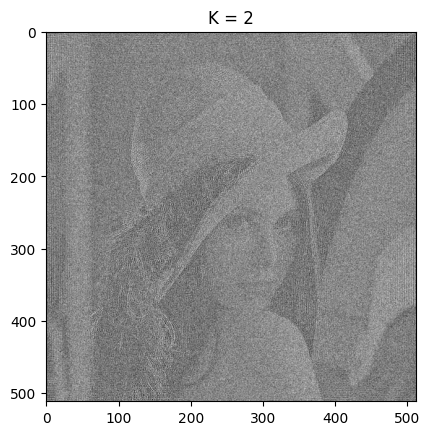

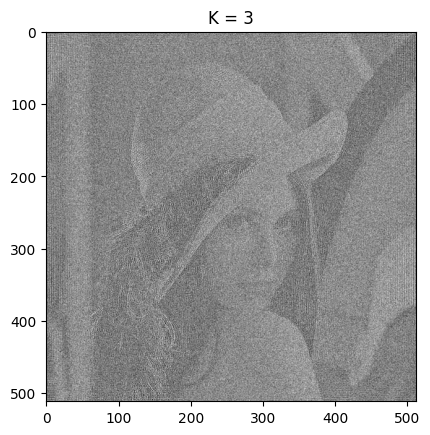

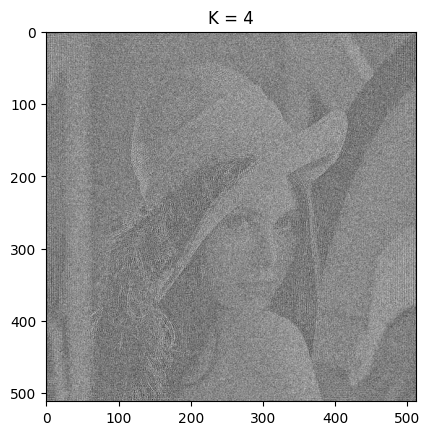

In [28]:
# Exemple d'essai avec différents K
# K = nombre d'itérations (data step + prior step)
# On utilise .half() pour réduire la mémoire GPU

kernel = gaussian_kernel(size=3, sigma=1.0).to(device)

for K in range(1, 5, 1):
    
    model = PnPUnrolled(kernel, K=K).to(device)
    
    # Désactivation de l'entraînement du débruiteur
    for p in model.denoiser.parameters():
        p.requires_grad = False

    # Passage de l'image en half
    image_noised = image_noised.to(device)
    
    # Pas de gradients pendant l'inférence
    with torch.no_grad():
        out = model(image_noised)
    
    # Affichage
    plt.imshow(out.detach().cpu().numpy()[0][0], cmap="gray")
    plt.title(f"K = {K}")
    plt.show()

    # Libération explicite de la mémoire GPU à chaque itération
    torch.cuda.empty_cache()


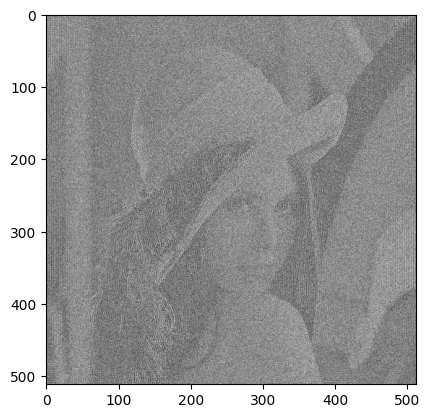

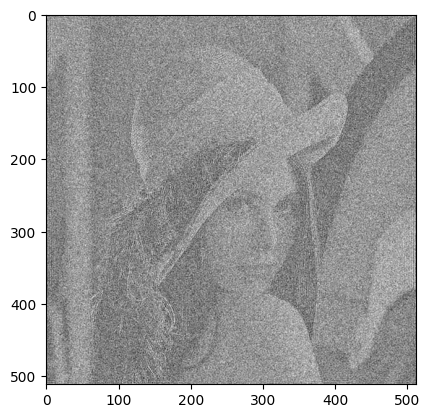

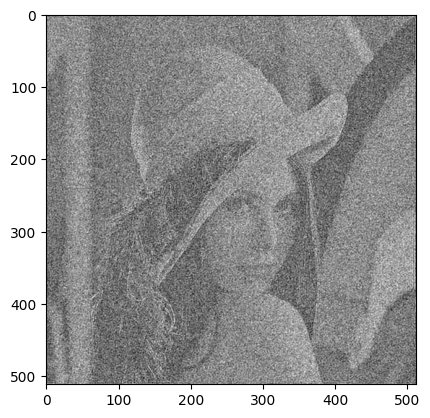

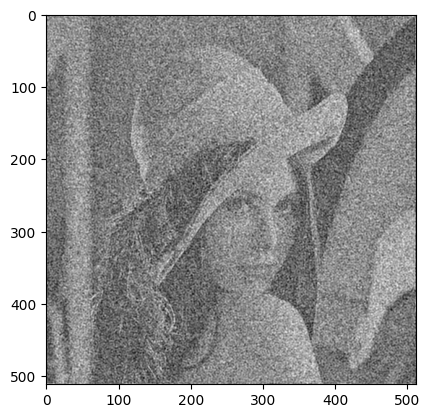

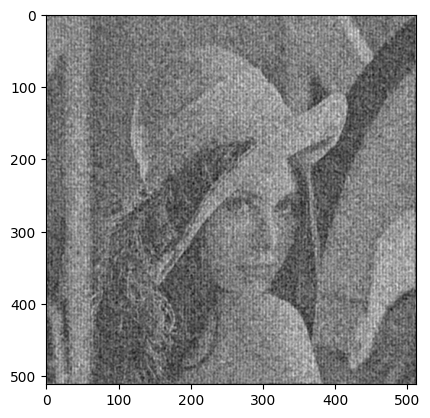

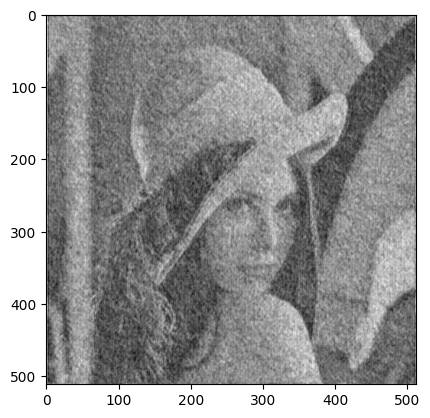

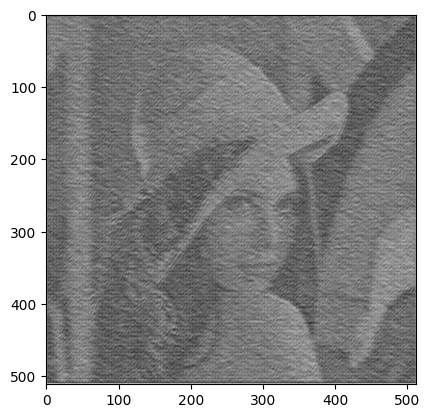

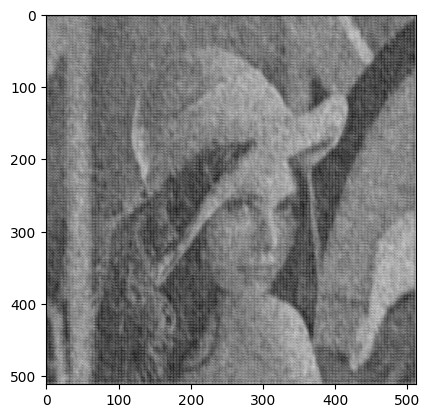

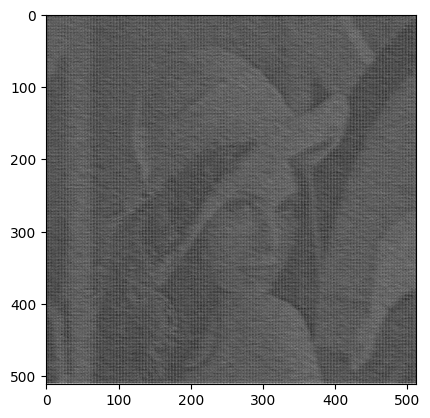

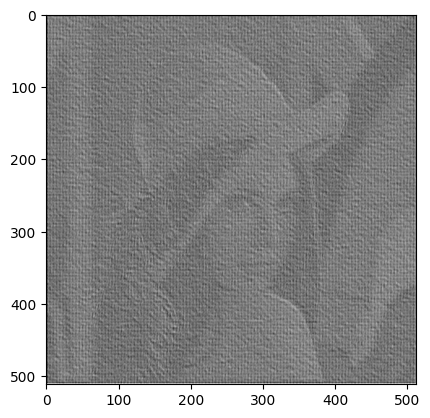

In [30]:
# grand impact de sigma

kernel = gaussian_kernel(size=3, sigma=1.0).to(device)

for sigma in np.logspace(-2, 2.3, num=10):
    model = PnPUnrolled(kernel, K=3, sigma = sigma).to(device)
    out = model(image_noised)
    plt.imshow(out.detach().cpu().numpy()[0][0],  cmap="gray")
    plt.show()